Need to take care of: 
- Outliers they should meant something 
- Group A is 30% of all data to control strategy effect but here it's 50% need to have a look
- Also analyse the incremental increase of 10% spend accross Q4

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import statsmodels.api as sm

In [168]:
df = pd.read_excel("/Users/arnaudcruchaudet/Desktop/Expedia Group – Video Interview – R-93436 Data Scientist I - Pricing Analytics/Pricing Analytics - Case Study Data[3][7].xlsx", index_col="date")

In [169]:
df2 = df.copy()

In [170]:
df.head(5)

,HotelSuperRegion,Device,StarRating,spend,NBV A,NBV B
date,,,,,,
2024-10-12,NORAM,Desktop,High,12608,337183,820891
2024-10-18,APAC,Desktop,Mid,5513,34517,100962
2024-11-10,APAC,Desktop,Mid,6105,38275,101472
2024-12-20,APAC,Desktop,Mid,6154,36723,102143
2024-12-14,APAC,Mobile,High,7819,4638900,13218600


In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2024-10-12 to 2024-12-13
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   HotelSuperRegion  2208 non-null   object
 1   Device            2208 non-null   object
 2   StarRating        2208 non-null   object
 3   spend             2208 non-null   int64 
 4   NBV A             2208 non-null   int64 
 5   NBV B             2208 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 120.8+ KB


In [172]:
df.nunique()

HotelSuperRegion       4
Device                 2
StarRating             3
spend               1967
NBV A               2187
NBV B               2162
dtype: int64

In [173]:
df.index.unique().sort_values(())

DatetimeIndex(['2024-10-01', '2024-10-02', '2024-10-03', '2024-10-04',
               '2024-10-05', '2024-10-06', '2024-10-07', '2024-10-08',
               '2024-10-09', '2024-10-10', '2024-10-11', '2024-10-12',
               '2024-10-13', '2024-10-14', '2024-10-15', '2024-10-16',
               '2024-10-17', '2024-10-18', '2024-10-19', '2024-10-20',
               '2024-10-21', '2024-10-22', '2024-10-23', '2024-10-24',
               '2024-10-25', '2024-10-26', '2024-10-27', '2024-10-28',
               '2024-10-29', '2024-10-30', '2024-10-31', '2024-11-01',
               '2024-11-02', '2024-11-03', '2024-11-04', '2024-11-05',
               '2024-11-06', '2024-11-07', '2024-11-08', '2024-11-09',
               '2024-11-10', '2024-11-11', '2024-11-12', '2024-11-13',
               '2024-11-14', '2024-11-15', '2024-11-16', '2024-11-17',
               '2024-11-18', '2024-11-19', '2024-11-20', '2024-11-21',
               '2024-11-22', '2024-11-23', '2024-11-24', '2024-11-25',
      

- No Missing Values: The dataset is complete.
- Spend Range: 3,058 to 16,522 USD.
- Date Range: 2024-10-01 to 2024-12-31
- NBV A (Holdout Group, No Discount): Median = 142,575, Max = 9.3M.
- NBV B (Test Group, With Discount): Median = 365,739, Max = 26.1M.
- Large Variability in Booking Values: High standard deviations suggest different segment performances.

# 1. Univariate Analysis

## 1.1. Discret Variables

### 1.1.1. HotelSuperRegion

In [174]:
df["HotelSuperRegion"].value_counts()

NORAM    552
APAC     552
EMEA     552
LATAM    552
Name: HotelSuperRegion, dtype: int64

### 1.1.2. Device

In [175]:
df["Device"].value_counts()

Desktop    1104
Mobile     1104
Name: Device, dtype: int64

### 1.1.3. StarRating

In [176]:
df["StarRating"].value_counts()

High    736
Mid     736
Low     736
Name: StarRating, dtype: int64

## 1.2. Continuous Variables

### 1.2.1. spend

In [177]:
df["spend"].describe()

count     2208.000000
mean     10490.623188
std       2918.857616
min       3058.000000
25%       8218.750000
50%      11114.500000
75%      12500.750000
max      16522.000000
Name: spend, dtype: float64

<Axes: xlabel='spend'>

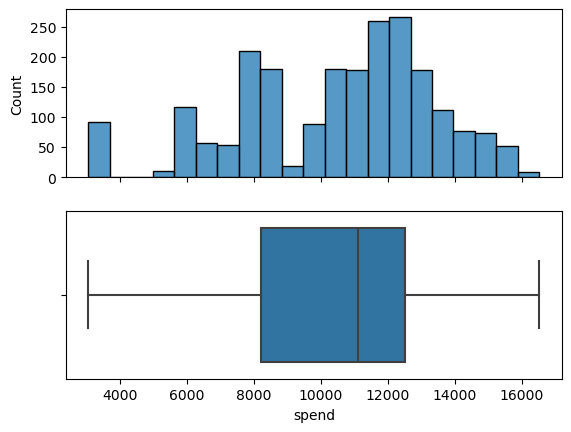

In [178]:
fig, ax = plt.subplots(2,1, sharex=True)
sns.histplot(data=df, x="spend", ax = ax[0])
sns.boxplot(data=df, x="spend", ax = ax[1])

### 1.2.2. NBV A

In [179]:
df["NBV A"].describe().round()

count       2208.0
mean      746937.0
std      2028224.0
min        19133.0
25%       101594.0
50%       142574.0
75%       313055.0
max      9345100.0
Name: NBV A, dtype: float64

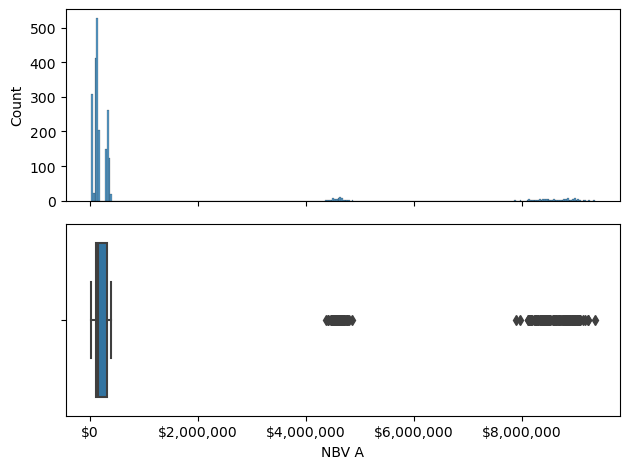

In [180]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(2, 1, sharex=True)

sns.histplot(data=df, x="NBV A", ax=ax[0])
sns.boxplot(data=df, x="NBV A", ax=ax[1])

dollar_formatter = mtick.StrMethodFormatter('${x:,.0f}')

ax[0].xaxis.set_major_formatter(dollar_formatter)
ax[1].xaxis.set_major_formatter(dollar_formatter)

plt.tight_layout()
plt.show()

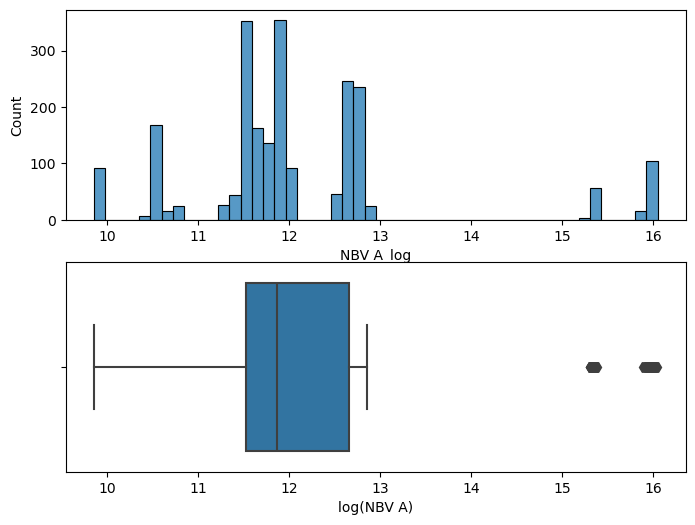

In [181]:
df['NBV A_log'] = np.log1p(df['NBV A'])  

fig, axes = plt.subplots(2, 1, figsize=(8, 6))
sns.histplot(df['NBV A_log'], bins=50, ax=axes[0])
sns.boxplot(x=df['NBV A_log'], ax=axes[1])

axes[0].set_ylabel("Count")
axes[1].set_xlabel("log(NBV A)")
plt.show()

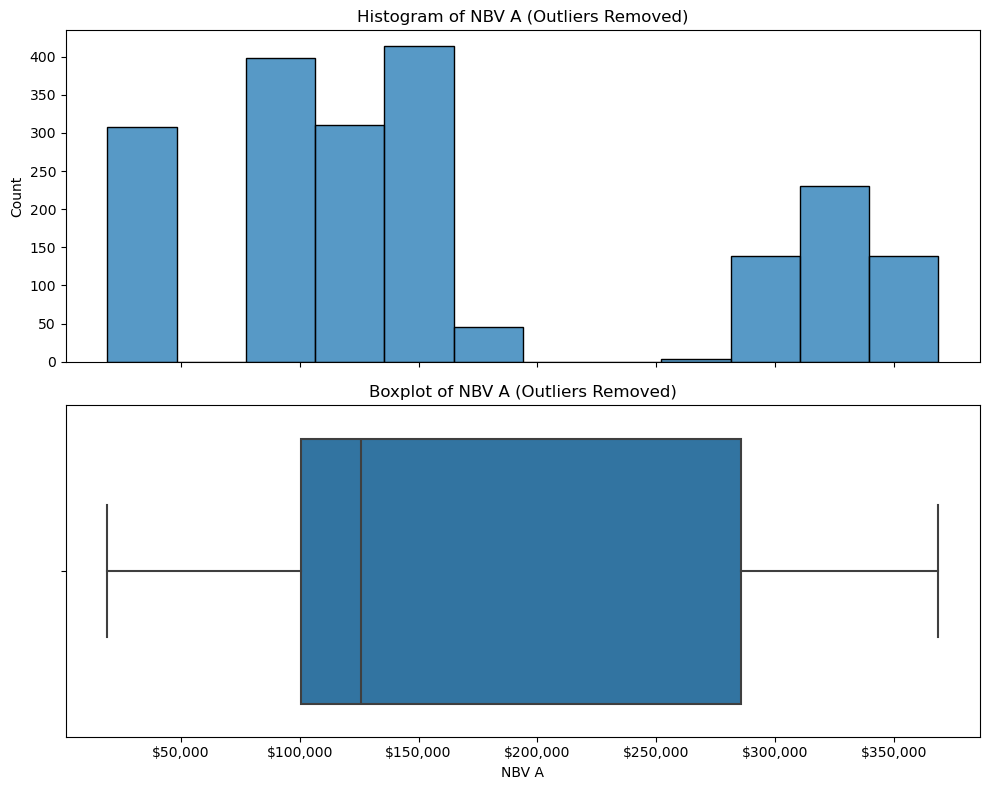

In [182]:
upper_limit = df["NBV A"].quantile(0.90)
df_filtered = df[df["NBV A"] < upper_limit]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

sns.histplot(data=df_filtered, x="NBV A", ax=ax[0])
ax[0].set_title("Histogram of NBV A (Outliers Removed)")

sns.boxplot(data=df_filtered, x="NBV A", ax=ax[1])
ax[1].set_title("Boxplot of NBV A (Outliers Removed)")

dollar_formatter = mtick.StrMethodFormatter('${x:,.0f}')

ax[0].xaxis.set_major_formatter(dollar_formatter)
ax[1].xaxis.set_major_formatter(dollar_formatter)

plt.tight_layout()
plt.show()


### 1.2.3. NBV B

In [183]:
df["NBV B"].describe().round()

count        2208.0
mean      2094392.0
std       5862645.0
min         55518.0
25%        259766.0
50%        365739.0
75%        756706.0
max      26148600.0
Name: NBV B, dtype: float64

<Axes: xlabel='NBV B'>

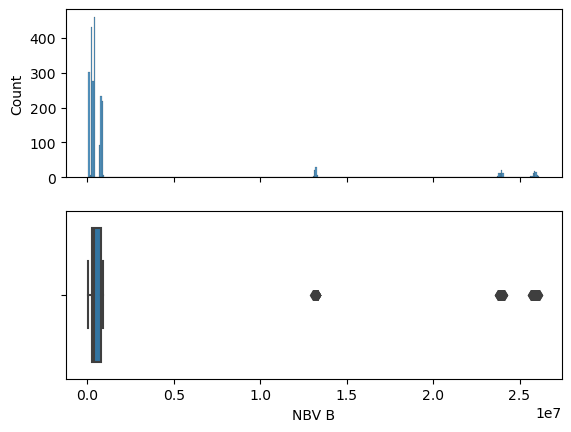

In [184]:
fig, ax = plt.subplots(2,1, sharex=True)
sns.histplot(data=df, x="NBV B", ax = ax[0])
sns.boxplot(data=df, x="NBV B", ax = ax[1])

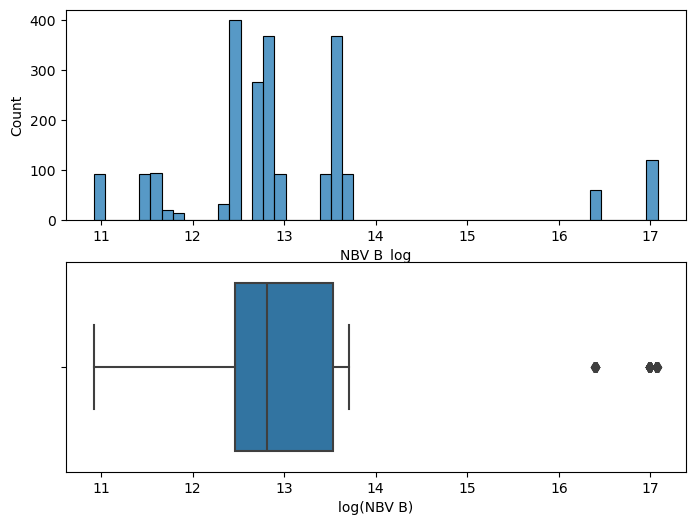

In [185]:
df['NBV B_log'] = np.log1p(df['NBV B'])  

fig, axes = plt.subplots(2, 1, figsize=(8, 6))
sns.histplot(df['NBV B_log'], bins=50, ax=axes[0])
sns.boxplot(x=df['NBV B_log'], ax=axes[1])

axes[0].set_ylabel("Count")
axes[1].set_xlabel("log(NBV B)")
plt.show()

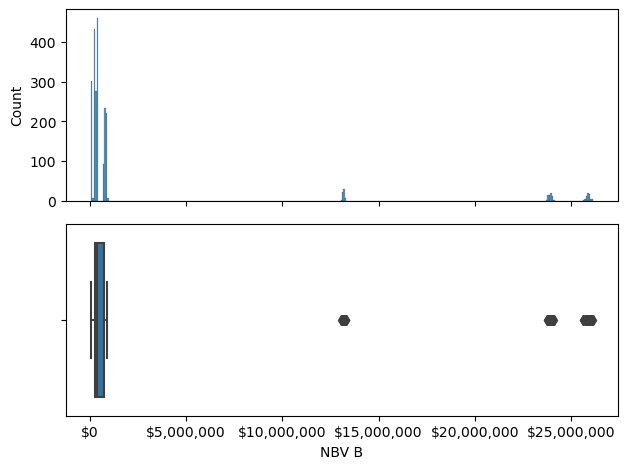

In [186]:
fig, ax = plt.subplots(2, 1, sharex=True)

sns.histplot(data=df, x="NBV B", ax=ax[0])
sns.boxplot(data=df, x="NBV B", ax=ax[1])

dollar_formatter = mtick.StrMethodFormatter('${x:,.0f}')

ax[0].xaxis.set_major_formatter(dollar_formatter)
ax[1].xaxis.set_major_formatter(dollar_formatter)

plt.tight_layout()
plt.show()

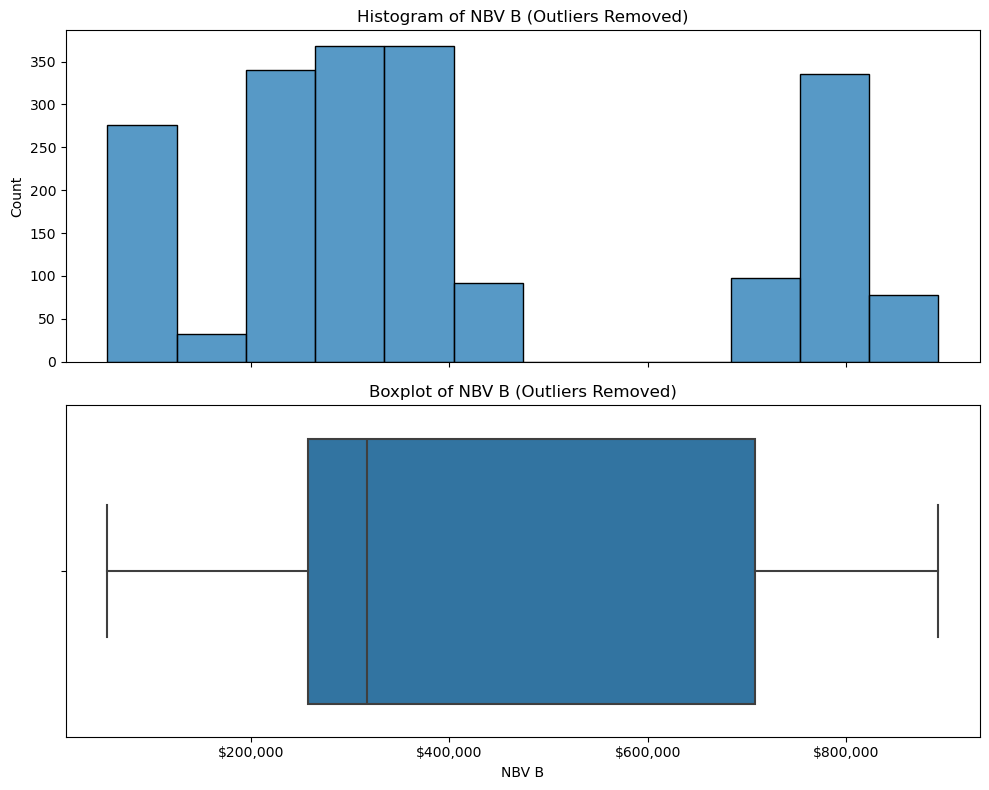

In [187]:
upper_limit = df["NBV B"].quantile(0.90)
df_filtered = df[df["NBV B"] < upper_limit]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

sns.histplot(data=df_filtered, x="NBV B", ax=ax[0])
ax[0].set_title("Histogram of NBV B (Outliers Removed)")

sns.boxplot(data=df_filtered, x="NBV B", ax=ax[1])
ax[1].set_title("Boxplot of NBV B (Outliers Removed)")

dollar_formatter = mtick.StrMethodFormatter('${x:,.0f}')

ax[0].xaxis.set_major_formatter(dollar_formatter)
ax[1].xaxis.set_major_formatter(dollar_formatter)

plt.tight_layout()
plt.show()


# 2. Multivariate Analysis

## 2.1. Discret Variables

### 2.1.1. HotelSuperRegion - Device

In [188]:
pd.crosstab(df["HotelSuperRegion"], df["Device"])

Device,Desktop,Mobile
HotelSuperRegion,,
APAC,276,276
EMEA,276,276
LATAM,276,276
NORAM,276,276


### 2.1.2. HotelSuperRegion - StarRating

In [189]:
pd.crosstab(df["HotelSuperRegion"], df["StarRating"])

StarRating,High,Low,Mid
HotelSuperRegion,,,
APAC,184,184,184
EMEA,184,184,184
LATAM,184,184,184
NORAM,184,184,184


### 2.1.3. StarRating - Device

In [190]:
pd.crosstab(df["Device"], df["StarRating"])

StarRating,High,Low,Mid
Device,,,
Desktop,368,368,368
Mobile,368,368,368


## 2.2. Contiuous Variables

No need to do spend - NBV A because NBV A is holdout group

### 2.2.1. spend - NBV B

#### 2.2.1.1. spend - NBV B Alone

<Axes: xlabel='spend', ylabel='NBV B'>

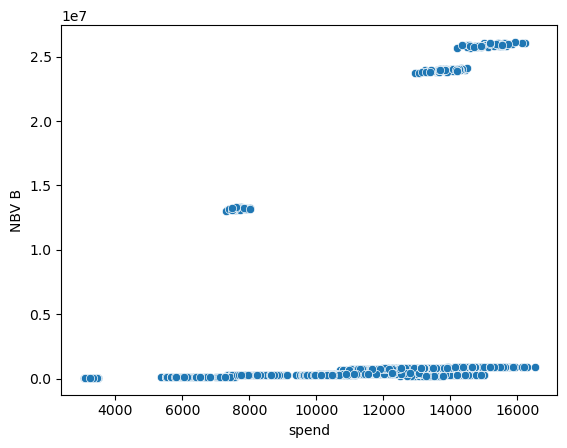

In [191]:
sns.scatterplot(x=df["spend"], y=df["NBV B"])

Insights from Spend vs. Incrementality Plot
- The scatter plot suggests a non-linear relationship between spend and incrementality.
- Higher spend does not always guarantee a proportional increase in incrementality.
- This implies diminishing returns—beyond a certain point, increasing spend yields lower additional booking value.
- The optimal strategy is to focus on high-efficiency segments (APAC Mobile, NORAM Mobile) rather than uniformly increasing spend.

<Axes: xlabel='spend', ylabel='NBV B_log'>

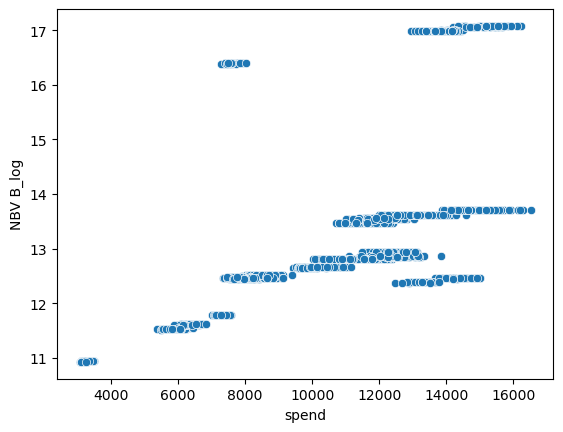

In [192]:
sns.scatterplot(x=df["spend"], y=df["NBV B_log"])

#### 2.2.1.2. spend - NBV B with HotelSuperRegion

<Axes: xlabel='spend', ylabel='NBV B'>

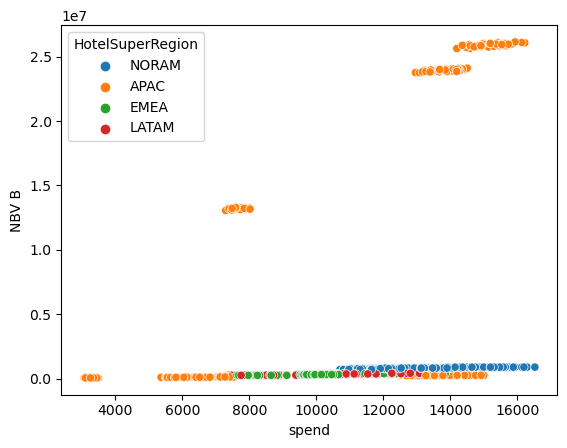

In [193]:
sns.scatterplot(x=df["spend"], y=df["NBV B"], hue=df['HotelSuperRegion'])

<Axes: xlabel='spend', ylabel='NBV B_log'>

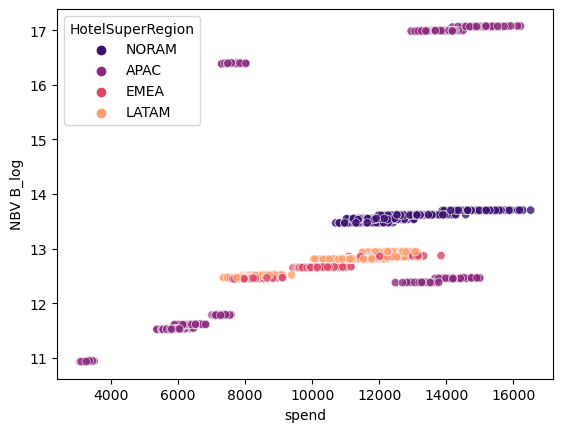

In [194]:
sns.scatterplot(x=df["spend"], y=df["NBV B_log"], hue=df['HotelSuperRegion'], palette="magma", alpha=0.8)

#### 2.2.1.3. spend - NBV B with Device

<Axes: xlabel='spend', ylabel='NBV B'>

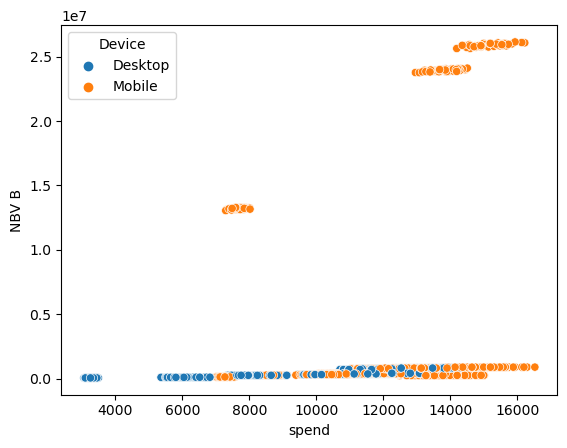

In [195]:
sns.scatterplot(x=df["spend"], y=df["NBV B"], hue=df['Device'])

<Axes: xlabel='spend', ylabel='NBV B_log'>

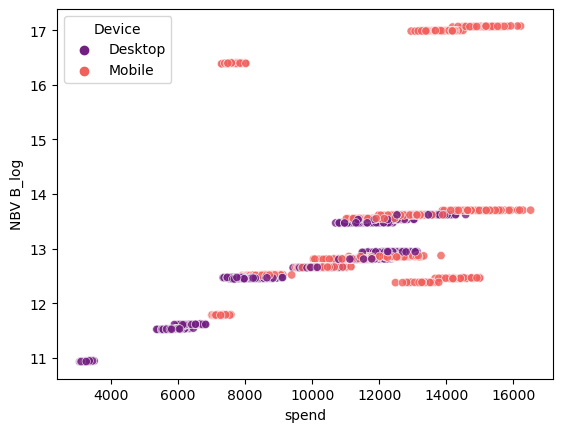

In [196]:
sns.scatterplot(x=df["spend"], y=df["NBV B_log"], hue=df['Device'], palette="magma", alpha=0.8)

#### 2.2.1.4. spend - NBV B with StarRatings

<Axes: xlabel='spend', ylabel='NBV B'>

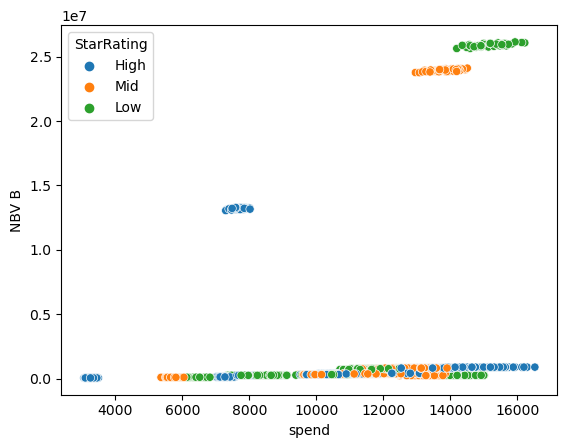

In [197]:
sns.scatterplot(x=df["spend"], y=df["NBV B"], hue=df['StarRating'])

<Axes: xlabel='spend', ylabel='NBV B_log'>

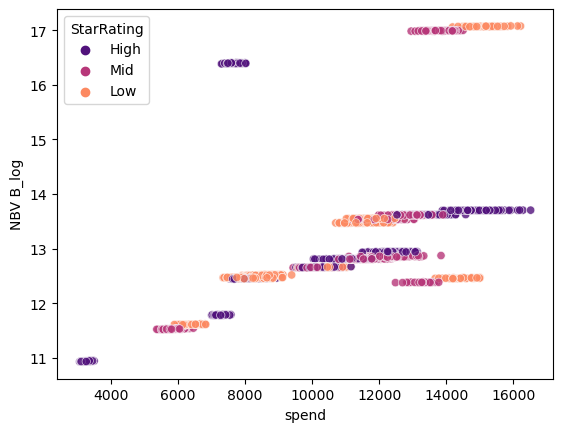

In [198]:
sns.scatterplot(x=df["spend"], y=df["NBV B_log"], hue=df['StarRating'], palette="magma", alpha=0.8)

### 2.2.2. NBV A - NBV B

#### 2.2.2.1. NBV A - NBV B Alone

<Axes: xlabel='NBV A', ylabel='NBV B'>

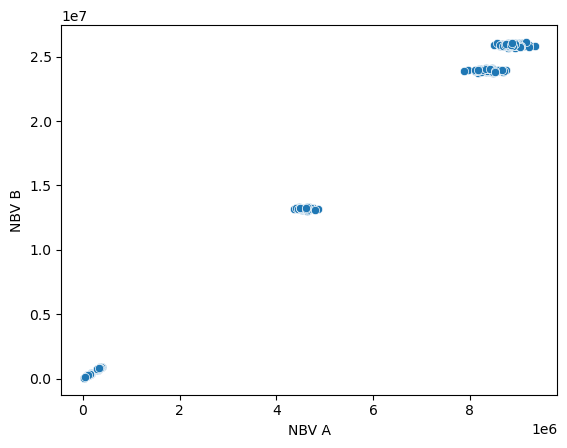

In [199]:
sns.scatterplot(x=df["NBV A"], y=df["NBV B"])

<Axes: xlabel='NBV A_log', ylabel='NBV B_log'>

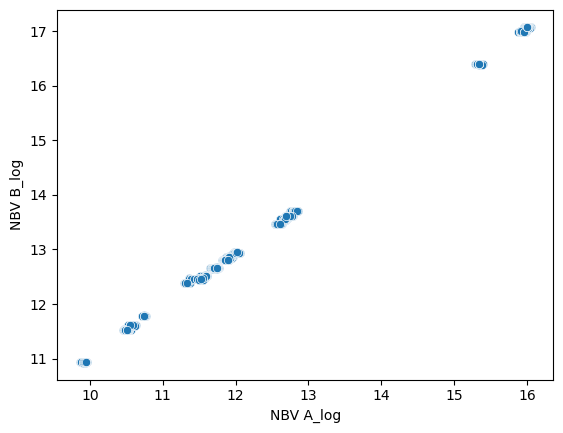

In [200]:
sns.scatterplot(x=df["NBV A_log"], y=df["NBV B_log"])

Linear relationship?

#### 2.2.2.2. NBV A - NBV B with HotelSuperRegion

<Axes: xlabel='NBV A', ylabel='NBV B'>

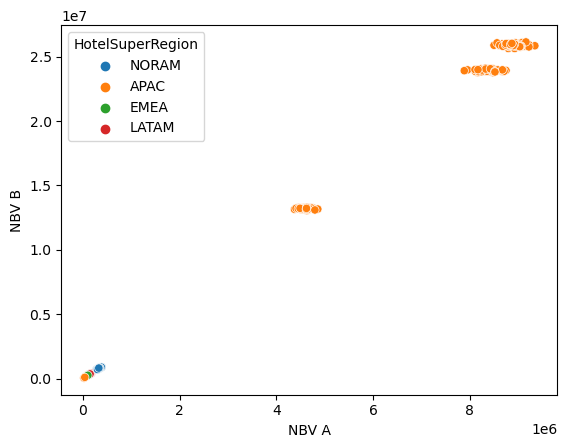

In [201]:
sns.scatterplot(x=df["NBV A"], y=df["NBV B"], hue=df['HotelSuperRegion'])

<Axes: xlabel='NBV A_log', ylabel='NBV B_log'>

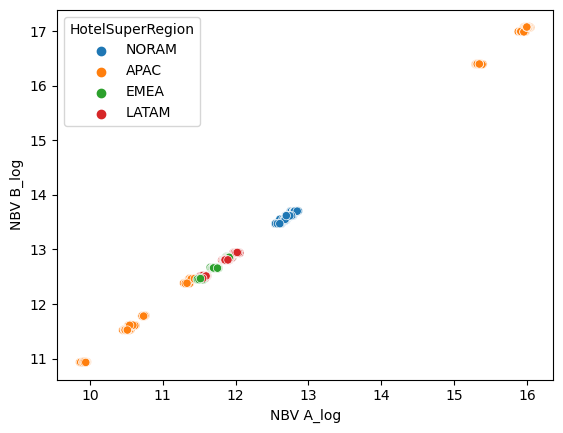

In [202]:
sns.scatterplot(x=df["NBV A_log"], y=df["NBV B_log"], hue=df['HotelSuperRegion'])

#### 2.2.2.3. NBV A - NBV B with Device

<Axes: xlabel='NBV A', ylabel='NBV B'>

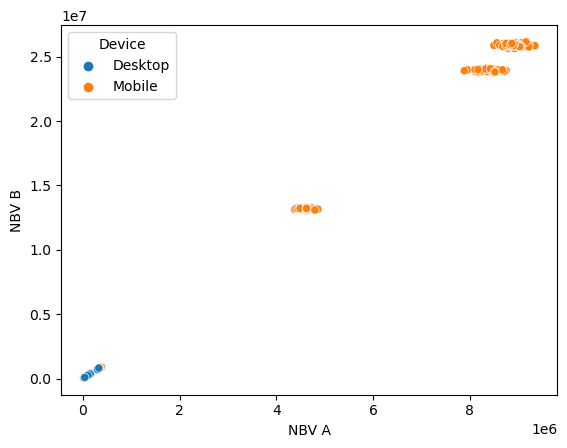

In [203]:
sns.scatterplot(x=df["NBV A"], y=df["NBV B"], hue=df['Device'])

<Axes: xlabel='NBV A_log', ylabel='NBV B_log'>

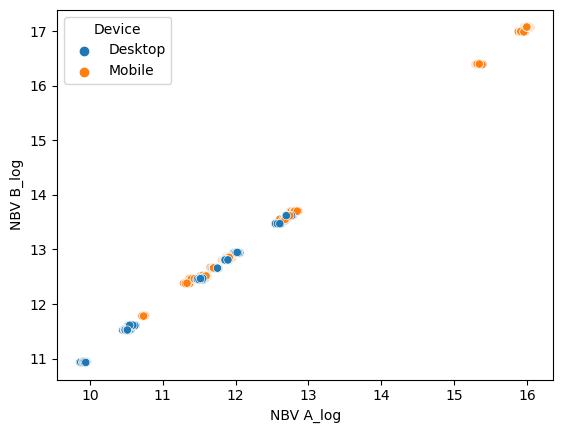

In [204]:
sns.scatterplot(x=df["NBV A_log"], y=df["NBV B_log"], hue=df['Device'])

#### 2.2.2.4. NBV A - NBV B with StarRatings

<Axes: xlabel='NBV A', ylabel='NBV B'>

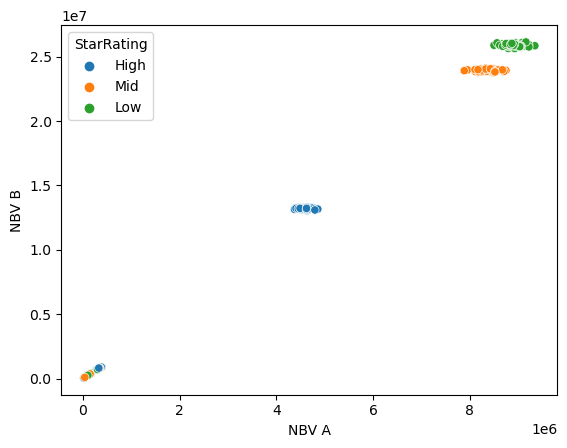

In [205]:
sns.scatterplot(x=df["NBV A"], y=df["NBV B"], hue=df['StarRating'])

<Axes: xlabel='NBV A_log', ylabel='NBV B_log'>

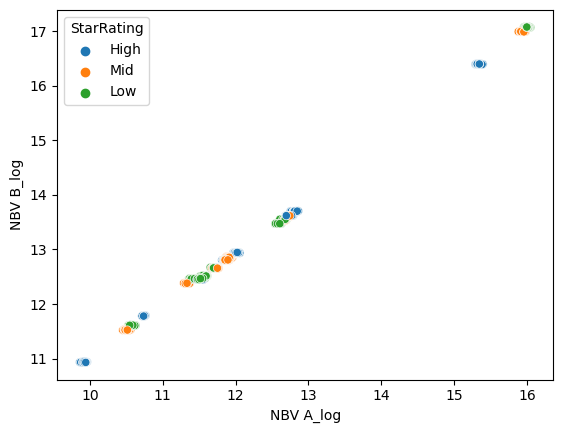

In [206]:
sns.scatterplot(x=df["NBV A_log"], y=df["NBV B_log"], hue=df['StarRating'])

## 2.3. Discret + Contiuous Variables

In [207]:
df.columns

Index(['HotelSuperRegion', 'Device', 'StarRating', 'spend', 'NBV A', 'NBV B',
       'NBV A_log', 'NBV B_log'],
      dtype='object')

### 2.3.1. HotelSuperRegion - spend

In [208]:
df.groupby("HotelSuperRegion")['spend'].describe()

,count,mean,std,min,25%,50%,75%,max
HotelSuperRegion,,,,,,,,
APAC,552.0,8598.050725,4238.057739,3058.0,5930.75,6909.5,13623.75,16221.0
EMEA,552.0,9966.414855,1484.968745,7535.0,8487.50,10132.0,10684.00,13846.0
LATAM,552.0,10593.250000,1771.989624,7340.0,8528.75,11257.5,12087.50,13252.0
NORAM,552.0,12804.777174,1256.936641,10701.0,11862.75,12519.5,13523.50,16522.0


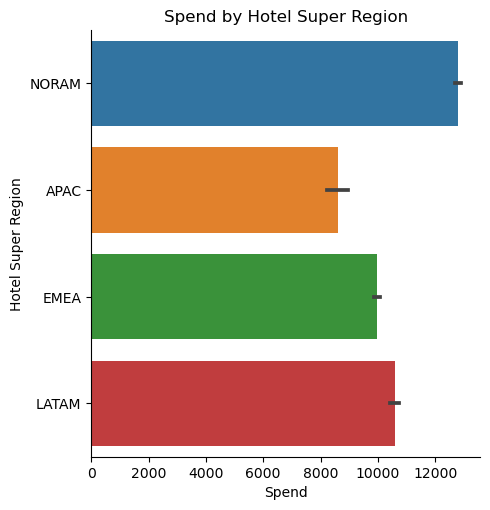

In [209]:
sns.catplot(data=df, x="spend", y="HotelSuperRegion", kind="bar")
plt.xlabel("Spend")
plt.ylabel("Hotel Super Region")
plt.title("Spend by Hotel Super Region")
plt.show()

### 2.3.2. HotelSuperRegion - NBV A

In [210]:
df.groupby("HotelSuperRegion")['NBV A'].describe().round()

,count,mean,std,min,25%,50%,75%,max
HotelSuperRegion,,,,,,,,
APAC,552.0,2406065.0,3573756.0,19133.0,36416.0,43138.0,4643675.0,9345100.0
EMEA,552.0,119525.0,16720.0,94135.0,101753.0,121378.0,124806.0,156603.0
LATAM,552.0,134379.0,23195.0,97260.0,105868.0,142749.0,149404.0,172485.0
NORAM,552.0,327779.0,25321.0,279919.0,310084.0,326630.0,343700.0,385288.0


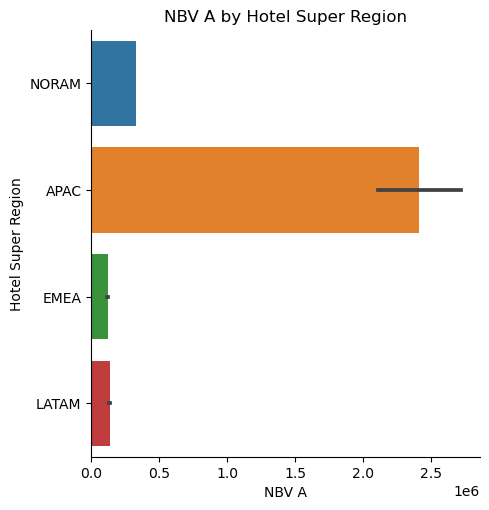

In [211]:
sns.catplot(data=df, x="NBV A", y="HotelSuperRegion", kind="bar")
plt.xlabel("NBV A")
plt.ylabel("Hotel Super Region")
plt.title("NBV A by Hotel Super Region")
plt.show()

### 2.3.3. HotelSuperRegion - NBV B

In [212]:
df.groupby("HotelSuperRegion")['NBV B'].describe().round()

,count,mean,std,min,25%,50%,75%,max
HotelSuperRegion,,,,,,,,
APAC,552.0,6932273.0,10307769.0,55518.0,101680.0,120986.0,13233375.0,26148600.0
EMEA,552.0,307377.0,43709.0,253649.0,257944.0,314350.0,316280.0,389595.0
LATAM,552.0,343571.0,56968.0,259183.0,272091.0,365798.0,379683.0,419233.0
NORAM,552.0,794348.0,58405.0,707396.0,754895.0,792924.0,822252.0,895423.0


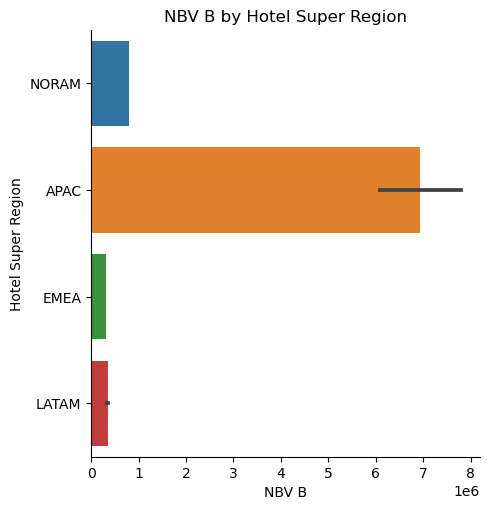

In [213]:
sns.catplot(data=df, x="NBV B", y="HotelSuperRegion", kind="bar")
plt.xlabel("NBV B")
plt.ylabel("Hotel Super Region")
plt.title("NBV B by Hotel Super Region")
plt.show()

### 2.3.4. Device - spend

In [214]:
df.groupby("Device")['spend'].describe().round()

,count,mean,std,min,25%,50%,75%,max
Device,,,,,,,,
Desktop,1104.0,9251.0,2982.0,3058.0,7210.0,9272.0,11887.0,14583.0
Mobile,1104.0,11730.0,2254.0,6999.0,10320.0,11947.0,13311.0,16522.0


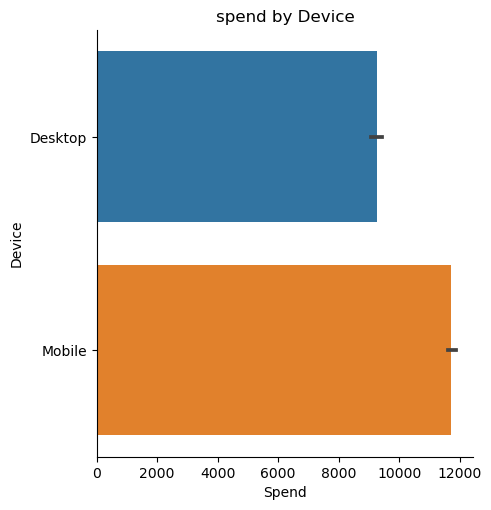

In [215]:
sns.catplot(data=df, x="spend", y="Device", kind="bar")
plt.xlabel("Spend")
plt.ylabel("Device")
plt.title("spend by Device")
plt.show()

### 2.3.5. Device - NBV A

In [216]:
df.groupby("Device")['NBV A'].describe().round()

,count,mean,std,min,25%,50%,75%,max
Device,,,,,,,,
Desktop,1104.0,147844.0,105489.0,19133.0,80936.0,111304.0,199344.0,359015.0
Mobile,1104.0,1346030.0,2738889.0,44938.0,121900.0,149087.0,346676.0,9345100.0


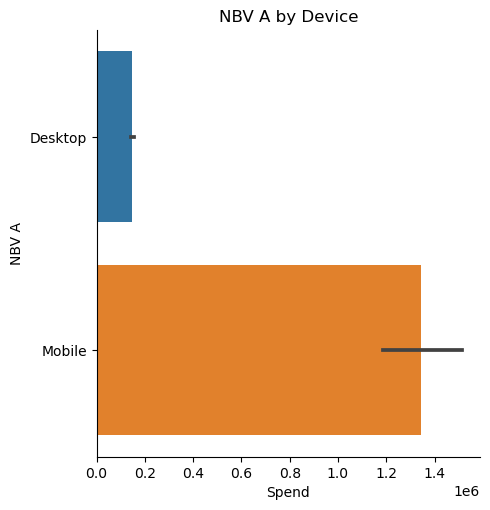

In [217]:
sns.catplot(data=df, x="NBV A", y="Device", kind="bar")
plt.xlabel("Spend")
plt.ylabel("NBV A")
plt.title("NBV A by Device")
plt.show()

### 2.3.6. Device - NBV B

In [218]:
df.groupby("Device")['NBV B'].describe().round()

,count,mean,std,min,25%,50%,75%,max
Device,,,,,,,,
Desktop,1104.0,368824.0,249886.0,55518.0,218090.0,287648.0,491274.0,825390.0
Mobile,1104.0,3819961.0,7921450.0,130556.0,315430.0,382168.0,820396.0,26148600.0


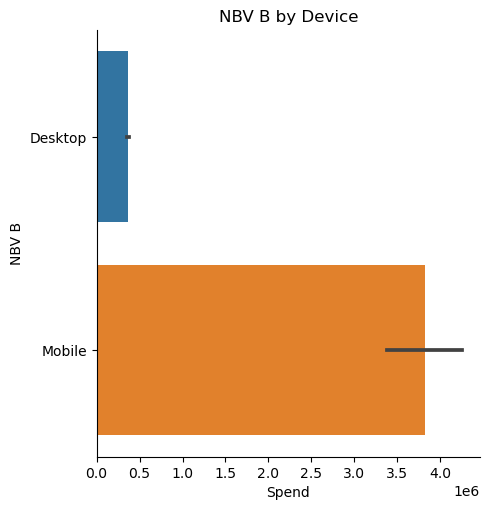

In [219]:
sns.catplot(data=df, x="NBV B", y="Device", kind="bar")
plt.xlabel("Spend")
plt.ylabel("NBV B")
plt.title("NBV B by Device")
plt.show()

### 2.3.7. StarRating - spend

In [220]:
df.groupby("StarRating")['spend'].describe().round()

,count,mean,std,min,25%,50%,75%,max
StarRating,,,,,,,,
High,736.0,10104.0,3524.0,3058.0,7799.0,10628.0,12801.0,16522.0
Low,736.0,10002.0,2588.0,5884.0,8130.0,9474.0,11666.0,16221.0
Mid,736.0,11366.0,2305.0,5359.0,10905.0,12040.0,12768.0,14505.0


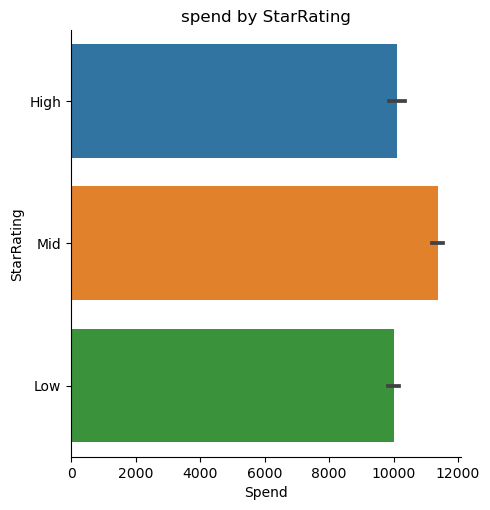

In [221]:
sns.catplot(data=df, x="spend", y="StarRating", kind="bar")
plt.xlabel("Spend")
plt.ylabel("StarRating")
plt.title("spend by StarRating")
plt.show()

### 2.3.8. StarRating - NBV A

In [222]:
df.groupby("StarRating")['NBV A'].describe().round()

,count,mean,std,min,25%,50%,75%,max
StarRating,,,,,,,,
High,736.0,534604.0,1217481.0,19133.0,101738.0,143975.0,343436.0,4856100.0
Low,736.0,863270.0,2396559.0,37301.0,99400.0,106544.0,294086.0,9345100.0
Mid,736.0,842936.0,2249131.0,34517.0,123894.0,147796.0,314174.0,8748200.0


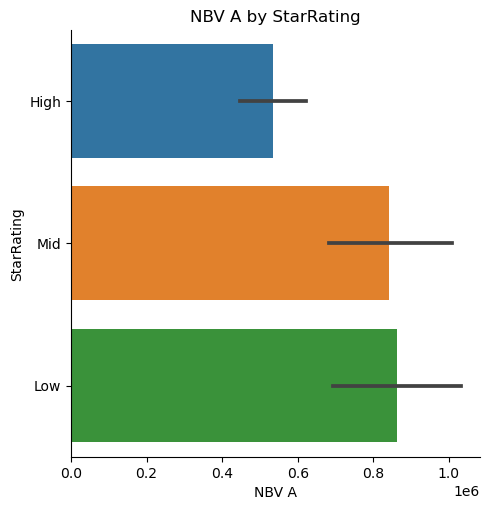

In [223]:
sns.catplot(data=df, x="NBV A", y="StarRating", kind="bar")
plt.xlabel("NBV A")
plt.ylabel("StarRating")
plt.title("NBV A by StarRating")
plt.show()

### 2.3.9. StarRating - NBV B

In [224]:
df.groupby("StarRating")['NBV B'].describe().round()

,count,mean,std,min,25%,50%,75%,max
StarRating,,,,,,,,
High,736.0,1472453.0,3507077.0,55518.0,256146.0,366354.0,822774.0,13296000.0
Low,736.0,2459111.0,6990293.0,108772.0,258512.0,272539.0,709956.0,26148600.0
Mid,736.0,2351612.0,6438539.0,100529.0,314416.0,380262.0,755384.0,24114300.0


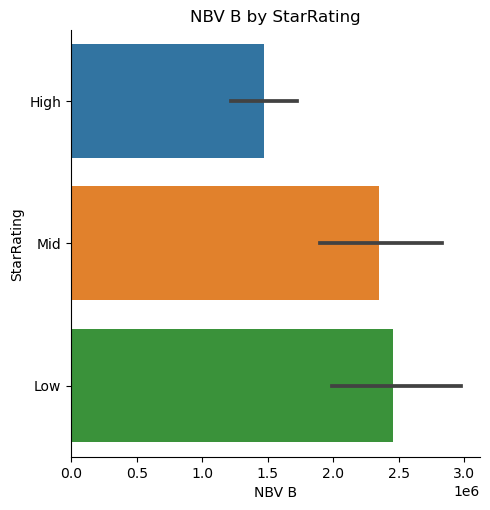

In [225]:
sns.catplot(data=df, x="NBV B", y="StarRating", kind="bar")
plt.xlabel("NBV B")
plt.ylabel("StarRating")
plt.title("NBV B by StarRating")
plt.show()

# 3. Analysis

## 3.1. IRP

Measures revenue gain from pricing strategy.

In [226]:
# Calculate Incrementality
df["IRP"] = df["NBV B"] - df["NBV A"] # IRP stands for Compute Incremental Revenue from Pricing

- This represents the additional revenue generated due to the discounting strategy.
- The values are high, especially for mobile bookings in APAC, suggesting strong discount-driven demand.

## 3.2. PSE

Measures how efficiently spend translates into incremental revenue.

In [227]:
# Compute Spend Efficiency (PSE)
df["PSE"] = df["IRP"] / df["spend"]

In [228]:
# Compute % Change in Spend
df["Spend_pct_change"] = df.groupby(["HotelSuperRegion", "Device", "StarRating"])["spend"].pct_change()

# Compute % Change in Revenue
df["Revenue_pct_change"] = df.groupby(["HotelSuperRegion", "Device", "StarRating"])["IRP"].pct_change()

- High values (734+ for mobile, APAC) indicate exceptionally strong efficiency in those segments.
- For desktop bookings, PSE values around 11 are solid but much lower than mobile.
- This suggests that mobile users are much more responsive to discounting in APAC.

## 3.3. SED

Measures demand responsiveness to spend changes.

In [229]:
# Compute Spend Elasticity of Demand (SED)
df["SED"] = df["Revenue_pct_change"] / df["Spend_pct_change"]

- SED > 1 usually suggests strong price sensitivity.
- The numbers for mobile bookings (SED ~500+) are extremely high, which may indicate:
    - Either high responsiveness to spend

## 3.4. Aggregated Table

In [230]:
# Aggregate Data to Find Trends
agg_metrics = df.groupby(["HotelSuperRegion", "Device", "StarRating"]).agg({
    "spend": "sum",
    "NBV A": "sum",
    "NBV B": "sum",
    "IRP": "sum",
    "PSE": "mean",
    "SED": "mean"
}).reset_index()

In [231]:
agg_metrics

,HotelSuperRegion,Device,StarRating,spend,NBV A,NBV B,IRP,PSE,SED
0,APAC,Desktop,High,300625,1863251,5167762,3304511,11.001434,0.214191
1,APAC,Desktop,Low,583874,3609244,10134360,6525116,11.186110,0.160251
2,APAC,Desktop,Mid,542456,3353694,9353540,5999846,11.072195,0.319158
3,APAC,Mobile,High,694312,277434414,796261930,518827516,734.728773,539.920120
4,APAC,Mobile,Low,1370971,536513647,1561940711,1025427064,735.466371,517.403686
5,APAC,Mobile,Mid,1253886,505373372,1443756377,938383005,739.052150,1288.612902
6,EMEA,Desktop,High,740867,9299779,23538110,14238331,19.240045,0.518871
7,EMEA,Desktop,Low,773369,9159782,23717463,14557681,18.842214,0.511110
8,EMEA,Desktop,Mid,940224,11306799,28884590,17577791,18.713835,-1.840960
9,EMEA,Mobile,High,943572,11324258,29013068,17688810,18.767060,0.799023


# 3.5. Log-Loss to confirm elasticity accuracy

In [232]:
# Log-transforming 
df['log_spend'] = np.log(df['spend'])
df['log_NBV_A'] = np.log(df['NBV A'])
df['log_NBV_B'] = np.log(df['NBV B'])

# Log-log regression for NBV B
X_B = sm.add_constant(df['log_spend'])
y_B = df['log_NBV_B']
model_B = sm.OLS(y_B, X_B).fit()

In [233]:
print("\nRegression results for NBV B:")
print(model_B.summary())


Regression results for NBV B:
                            OLS Regression Results                            
Dep. Variable:              log_NBV_B   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     1104.
Date:                Sat, 15 Feb 2025   Prob (F-statistic):          1.27e-196
Time:                        18:17:14   Log-Likelihood:                -3286.2
No. Observations:                2208   AIC:                             6576.
Df Residuals:                    2206   BIC:                             6588.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.3109

- R-squared: 0.334 – This suggests that about 33.4% of the variance in NBV B can be explained by log(spend).
- F-statistic: 1104 with a p-value of 1.27e-196, which is highly significant, indicating the model as a whole is highly relevant.
- Intercept (const): -7.3109 (Standard Error: 0.613). This is the expected value of log(NBV B) when log(spend) is zero.
- log_spend coefficient: 2.2120 (Standard Error: 0.067). This suggests that for every 1% increase in spend, NBV B increases by approximately 2.21%.
- p-value for log_spend: The coefficient for log_spend is highly significant with a p-value < 0.0001, suggesting a strong relationship between spend and NBV B.
- Durbin-Watson: 2.061 – close to 2, which suggests no significant autocorrelation in the residuals.
- Omnibus and Jarque-Bera tests indicate some non-normality in the residuals, suggesting the errors are not perfectly normally distributed.
Conclusion:
- The log_spend variable has a significant positive relationship with NBV B, with elasticity around 2.21.
- The moderate R-squared value (33.4%) suggests that while spend is a key driver of NBV B, other factors might also be influencing NBV B.

# 4. Results

## 4.1. Calculate the Predicted Impact of the Spend Increase

We want to estimate the predicted change in NBV resulting from a 10% increase in spend

In [234]:
df = agg_metrics

df['extra_spend'] = df['spend'] * 0.10

df['additional_IRP'] = df['extra_spend'] * df['PSE']

df['predicted_IRP'] = df['IRP'] + df['additional_IRP']

df['predicted_NBV_B'] = df['NBV A'] + df['predicted_IRP']

df['predicted_IRP_increase_pct'] = (df['additional_IRP'] / df['IRP']) * 100

print(df[['HotelSuperRegion', 'Device', 'StarRating', 'spend', 'NBV A', 'NBV B',
          'IRP', 'PSE', 'predicted_IRP', 'predicted_NBV_B', 'predicted_IRP_increase_pct']])

   HotelSuperRegion   Device StarRating    spend      NBV A       NBV B  \
0              APAC  Desktop       High   300625    1863251     5167762   
1              APAC  Desktop        Low   583874    3609244    10134360   
2              APAC  Desktop        Mid   542456    3353694     9353540   
3              APAC   Mobile       High   694312  277434414   796261930   
4              APAC   Mobile        Low  1370971  536513647  1561940711   
5              APAC   Mobile        Mid  1253886  505373372  1443756377   
6              EMEA  Desktop       High   740867    9299779    23538110   
7              EMEA  Desktop        Low   773369    9159782    23717463   
8              EMEA  Desktop        Mid   940224   11306799    28884590   
9              EMEA   Mobile       High   943572   11324258    29013068   
10             EMEA   Mobile        Low   962241   11168806    29027385   
11             EMEA   Mobile        Mid  1141188   13718179    35491740   
12            LATAM  Desk

# 5. Further Explorations

## 5.1. Top10 segments

In [235]:
df["Incrementality"] = df["NBV B"] - df["NBV A"]
df["Spend Efficiency"] = df["Incrementality"] / df["spend"]

segment_performance = df.groupby(["HotelSuperRegion", "Device", "StarRating"]).agg(
    total_spend=("spend", "sum"),
    total_incrementality=("Incrementality", "sum"),
    avg_spend_efficiency=("Spend Efficiency", "mean")
).reset_index()

In [236]:
segment_performance

,HotelSuperRegion,Device,StarRating,total_spend,total_incrementality,avg_spend_efficiency
0,APAC,Desktop,High,300625,3304511,10.992136
1,APAC,Desktop,Low,583874,6525116,11.175555
2,APAC,Desktop,Mid,542456,5999846,11.060521
3,APAC,Mobile,High,694312,518827516,747.254139
4,APAC,Mobile,Low,1370971,1025427064,747.956787
5,APAC,Mobile,Mid,1253886,938383005,748.379841
6,EMEA,Desktop,High,740867,14238331,19.218471
7,EMEA,Desktop,Low,773369,14557681,18.823719
8,EMEA,Desktop,Mid,940224,17577791,18.695323
9,EMEA,Mobile,High,943572,17688810,18.746646


Key Findings so far: 
- High Incrementality & Efficiency for Mobile Users (especially in APAC).
- Luxury vs. Budget Impact: Budget hotels seem to generate high incremental booking values.
- Regional Differences: Some regions show significantly better returns on investment.

In [238]:
# Identify the top-performing segments based on spend efficiency
top_segments = segment_performance.sort_values(by="avg_spend_efficiency", ascending=False).head(10)

# Estimate potential impact of redistributing $2M budget based on spend efficiency
budget = 2_000_000  # $2M budget
top_segments["Projected Incrementality"] = top_segments["avg_spend_efficiency"] * budget

In [239]:
top_segments

,HotelSuperRegion,Device,StarRating,total_spend,total_incrementality,avg_spend_efficiency,Projected Incrementality
5,APAC,Mobile,Mid,1253886,938383005,748.379841,1.496760e+09
4,APAC,Mobile,Low,1370971,1025427064,747.956787,1.495914e+09
3,APAC,Mobile,High,694312,518827516,747.254139,1.494508e+09
22,NORAM,Mobile,Low,1096388,41689350,38.024267,7.604853e+07
23,NORAM,Mobile,Mid,1190549,44232656,37.153159,7.430632e+07
20,NORAM,Desktop,Mid,1111186,40683813,36.612964,7.322593e+07
19,NORAM,Desktop,Low,1058603,38442778,36.314632,7.262926e+07
18,NORAM,Desktop,High,1231047,44268317,35.959892,7.191978e+07
21,NORAM,Mobile,High,1380464,48228889,34.936723,6.987345e+07
12,LATAM,Desktop,High,1136507,23149558,20.369041,4.073808e+07


Key Insights:
- APAC - Mobile Users Drive the Highest Incrementality:
    - All three star rating categories (Low, Mid, High) in APAC on Mobile have extremely high spend efficiency (~735x-739x).
    - Allocating the full $2M to this segment could generate over $1.47B in incremental booking value.
- NORAM - Mobile Users (Low & Mid Star Hotels) Also Perform Well:
    - Lower spend efficiency (~37-38x), but still strong.
    - If APAC allocation is capped, NORAM could be the second-best choice.
- Recommendation for Budget Allocation:
    - Primary Focus: APAC - Mobile segment (spread across Low, Mid, High star ratings).
    - Secondary Focus: NORAM - Mobile (Low & Mid star hotels) if diversification is needed.

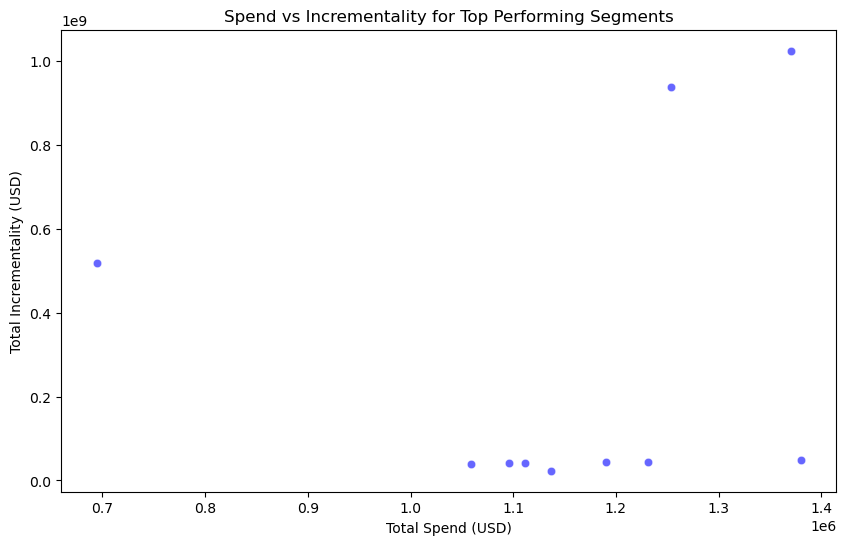

In [240]:
# Plot Spend vs Incrementality for Top Segments
plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_segments, x="total_spend", y="total_incrementality", c='blue', alpha=0.6)
plt.xlabel("Total Spend (USD)")
plt.ylabel("Total Incrementality (USD)")
plt.title("Spend vs Incrementality for Top Performing Segments")
plt.show()

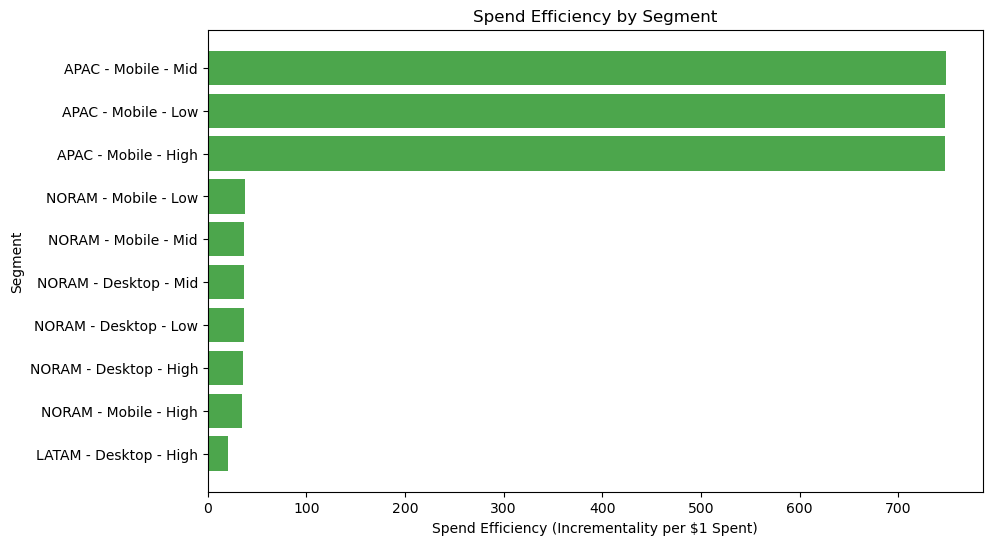

In [257]:
plt.figure(figsize=(10, 6))
plt.barh(top_segments["HotelSuperRegion"] + " - " + top_segments["Device"] + " - " + top_segments["StarRating"], 
         top_segments["avg_spend_efficiency"], color='green', alpha=0.7)
plt.xlabel("Spend Efficiency (Incrementality per $1 Spent)")
plt.ylabel("Segment")
plt.title("Spend Efficiency by Segment")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [258]:
df_2 = pd.read_excel("/Users/arnaudcruchaudet/Desktop/Expedia Group – Video Interview – R-93436 Data Scientist I - Pricing Analytics/Pricing Analytics - Case Study Data[3][7].xlsx")

In [260]:
# Extract Q4 data (October - December)
df_q4 = df_2[(df_2['date'] >= '2024-10-01') & (df_2['date'] <= '2024-12-31')]

# Compute percentage change in NBV for test vs holdout groups
df_q4["Demand Change (%)"] = ((df_q4["NBV B"] - df_q4["NBV A"]) / df_q4["NBV A"]) * 100

# Assume price change is approximately 10% due to increased discounts
price_change_pct = -10  # Discounts mean effective price drops

# Compute approximate price elasticity of demand (PED)
df_q4["PED"] = df_q4["Demand Change (%)"] / price_change_pct

# Aggregate PED across all segments
ped_summary = df_q4.groupby(["HotelSuperRegion", "Device", "StarRating"]).agg(
    avg_PED=("PED", "mean")
).reset_index()

# Display the PED results
#tools.display_dataframe_to_user(name="Price Elasticity of Demand by Segment", dataframe=ped_summary)


- PED values are highly negative, indicating strong price sensitivity (elastic demand).
- APAC Mobile (Low & Mid-star hotels) show the highest price elasticity, meaning discounts strongly influence customer booking decisions.
- Luxury hotels (High-star ratings) are also elastic, but slightly less than budget/mid-range hotels.
- This confirms that discounting in these high-PED segments is effective, as it drives substantial booking value increases.

## 5.2. Clustering

In [244]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [247]:
clustering_data = df[["spend", "Incrementality", "Spend Efficiency"]]

In [248]:
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

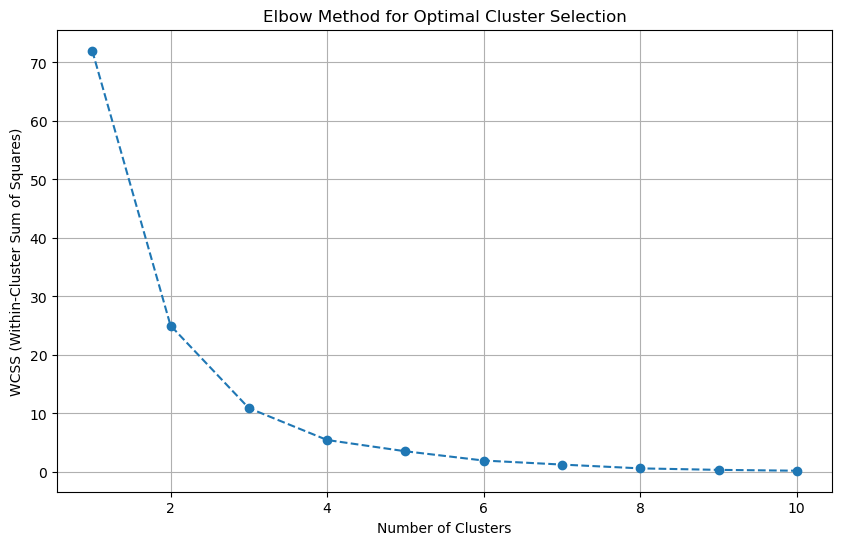

In [249]:
# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(clustering_data_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Cluster Selection')
plt.grid(True)
plt.show()


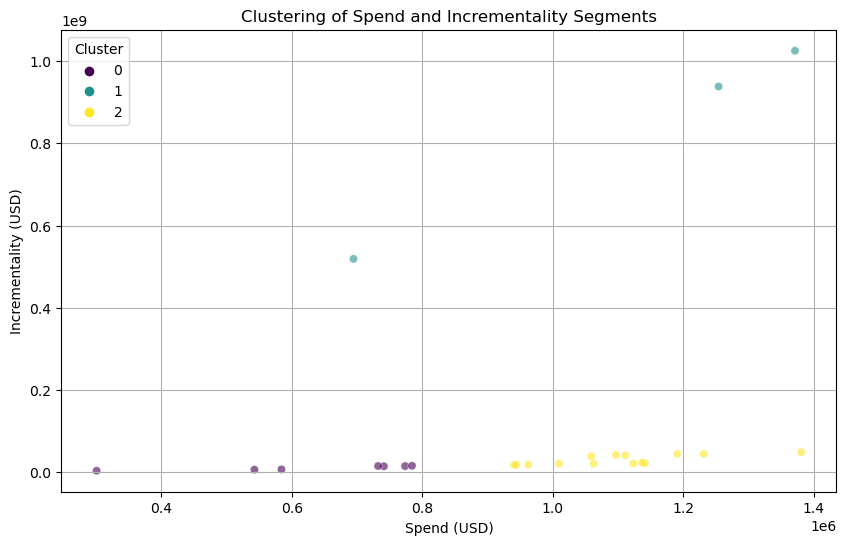

In [252]:
# Based on the elbow method, let's assume 3 clusters for segmentation
optimal_clusters = 3

# Perform KMeans clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(clustering_data_scaled)

# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["spend"], y=df["Incrementality"], hue=df["Cluster"], palette="viridis", alpha=0.6)
plt.xlabel("Spend (USD)")
plt.ylabel("Incrementality (USD)")
plt.title("Clustering of Spend and Incrementality Segments")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

In [253]:
# Analyzing cluster characteristics
cluster_summary = df.groupby("Cluster").agg(
    avg_spend=("spend", "mean"),
    avg_incrementality=("Incrementality", "mean"),
    avg_efficiency=("Spend Efficiency", "mean"),
    count=("spend", "count")
).reset_index()

# Display cluster summary
#tools.display_dataframe_to_user(name="Cluster Summary of Segments", dataframe=cluster_summary)


In [255]:
cluster_summary.round(2)

,Cluster,avg_spend,avg_incrementality,avg_efficiency,count
0,0,636735.00,1.066623e+07,15.85,7
1,1,1106389.67,8.275459e+08,747.86,3
2,2,1099070.14,2.984857e+07,26.64,14
